In [1]:
from jax import config
# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import hessian
from time import time
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_probability as tfp

from gpjax.base import static_field

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
def convert_to_1d_output_problem(X, Y): # [N, 2], [N, 2] -> [2*N, 3], [2*N, 1]
    #  helper function to map 2d->2d regression problem to 3d->1d regression problem
    label = jnp.tile(jnp.array([0.0, 1.0]), X.shape[0])[:,None] # [2*N, 1]
    X_1d = jnp.hstack([jnp.repeat(X, repeats=2, axis=0), label]) # [2*N, 3]
    Y_1d = jnp.reshape(Y, (-1, 1)) # [2*N, 1]
    return X_1d, Y_1d # [2*N, 3], [2*N, 1]



In [3]:
@dataclass
class IndepKernel(gpx.kernels.AbstractKernel):
    kernel0: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    kernel1: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0

        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k1_switch = z * zp

        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp)


@dataclass
class HelmholtzKernel(gpx.kernels.AbstractKernel):
    potential_kernel : gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    stream_kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # obtain indices for k_helm, implement in the correct sign between the derivatives
        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)
        sign = (-1) ** (z + zp)

        # convert to array to correctly index, -ve sign due to exchange symmetry (only true for stationary kernels)
        potential_dvtve = -jnp.array(
            hessian(self.potential_kernel)(X, Xp), dtype=jnp.float64
        )[z][zp]
        stream_dvtve = -jnp.array(
            hessian(self.stream_kernel)(X, Xp), dtype=jnp.float64
        )[1 - z][1 - zp]

        return potential_dvtve + sign * stream_dvtve
    
    
@dataclass
class FundamentalDomainKernel(gpx.kernels.AbstractKernel):
    kernel1: gpx.kernels.AbstractKernel = gpx.kernels.RBF()
    kernel2: gpx.kernels.AbstractKernel = gpx.kernels.RBF()

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # get output ids for each input
        z, zp = jnp.array(X[2], dtype=int), jnp.array(Xp[2], dtype=int)
        
        # map inputs to fundamental domain
        Pi_X = jnp.array([ jnp.sqrt(jnp.sum(X[:2] ** 2)), 0.0], dtype=jnp.float64) # [2]
        Pi_Xp = jnp.array([ jnp.sqrt(jnp.sum(Xp[:2] ** 2)), 0.0], dtype=jnp.float64) # [2]
        
        # Eval matrix-valued kernel (indep kernel for each output dimension, then rotate to correct output)
        K_base = jnp.array([[self.kernel1(Pi_X, Pi_Xp),0.0],[0.0, self.kernel2(Pi_X,Pi_Xp)]], dtype=jnp.float64) # [2, 2]
        rho_X = self._rho(jnp.arctan2(X[1], X[0])) # [2, 2]
        rho_Xp = self._rho(jnp.arctan2(Xp[1], Xp[0])) # [2, 2]
        K_A = rho_X.T @ K_base @ rho_Xp # [2, 2]
        
        return K_A[z][zp] # just return the kernel value for the requested output combination
    
    def _rho(self, theta): #[1] -> [2,2]
        # build rotation matrix for given angle
        return jnp.array([[jnp.cos(-theta), -jnp.sin(-theta)],[jnp.sin(-theta), jnp.cos(-theta)]], dtype=jnp.float64)









In [4]:
def run_experient(X, Y, X_test, Y_test, num_samples=3):
    # script to run an experiment

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.quiver(X_test[:,0],X_test[:,1],Y_test[:,0],Y_test[:,1],color=colors[0],label="Ground truth",angles="xy",scale=10,)
    ax.quiver(X[:,0],X[:,1],Y[:,0],Y[:,1],color=colors[1],label="Observations",angles="xy",scale=10,)
    plt.legend()

    X_1d, Y_1d = convert_to_1d_output_problem(X, Y)
    X_test_1d, Y_test_1d = convert_to_1d_output_problem(X_test, Y_test)
    D_train = gpx.Dataset(X_1d, Y_1d)
    D_test = gpx.Dataset(X_test_1d, Y_test_1d)
    names = ["Standard SE kernel", "Helmholtz kernel", "Fundamental domain kernel"]
    for idx, kernel in enumerate([IndepKernel(), HelmholtzKernel(), FundamentalDomainKernel()]):

        # Define, fit, predict, plot each GP
        t_0 = time()
        prior = prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=kernel)
        likelihood = gpx.likelihoods.Gaussian(num_datapoints=D_train.n, obs_stddev=jnp.array([1.0e-1], dtype=jnp.float64))
        posterior = prior * likelihood
        opt_posterior, _ = gpx.fit_scipy( # fit the model
                model=posterior,
                objective=gpx.objectives.ConjugateMLL(negative=True),
                train_data=D_train,
            )
        predictive_dist = opt_posterior.predict(D_test.X, train_data = D_train) # predict on test data
        Y_pred = predictive_dist.mean().reshape(-1,2) # [N_test, 2]
        samples = predictive_dist.sample(seed=key, sample_shape=(num_samples,)).reshape(num_samples, -1, 2) # [s, N_test, 2]
        
        fig, ax = plt.subplots(1, num_samples+1, figsize=(10, 3)) 
        for i in range(num_samples+1):
            if i==0: # plot the mean and observations
                ax[i].quiver(X_test[:,0],X_test[:,1],Y_pred[:,0],Y_pred[:,1],color=colors[0],label="Predictive Mean",angles="xy",scale=10,)
                ax[i].quiver(X[:,0],X[:,1],Y[:,0],Y[:,1],color=colors[1],label="Observations",angles="xy",scale=10,)
            else: # plot the samples
                ax[i].quiver(X_test[:,0],X_test[:,1],samples[i-1,:,0],samples[i-1,:,1],color=colors[0],label=f"Sample {i}",angles="xy",scale=10,)
                ax[i].quiver(X[:,0],X[:,1],Y[:,0],Y[:,1],color=colors[1],label="Observations",angles="xy",scale=10,)
            ax[i].legend()
            ax[i].set_title(names[idx])
        print(f"time to fit on {X.shape[0]} points and predict on {X_test.shape[0]} for "+names[idx]+f" is {time()-t_0}")
            
    
    


Optimization terminated successfully.
         Current function value: -21.434990
         Iterations: 68
         Function evaluations: 72
         Gradient evaluations: 72
time to fit on 5 points and predict on 1000 for Standard SE kernel is 1.8749890327453613


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -22.929048
         Iterations: 49
         Function evaluations: 76
         Gradient evaluations: 65
time to fit on 5 points and predict on 1000 for Helmholtz kernel is 3.974637985229492
Optimization terminated successfully.
         Current function value: -41.084003
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
time to fit on 5 points and predict on 1000 for Fundamental domain kernel is 1.3002970218658447


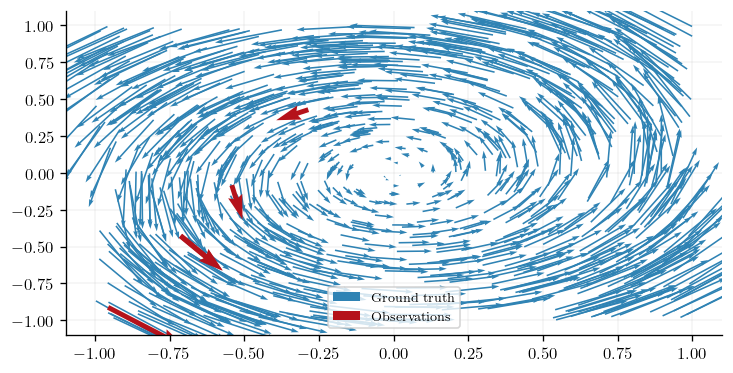

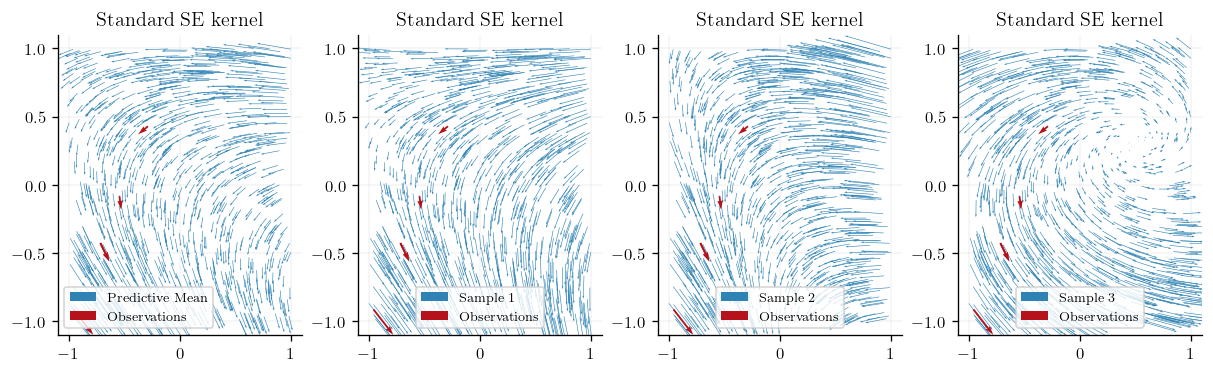

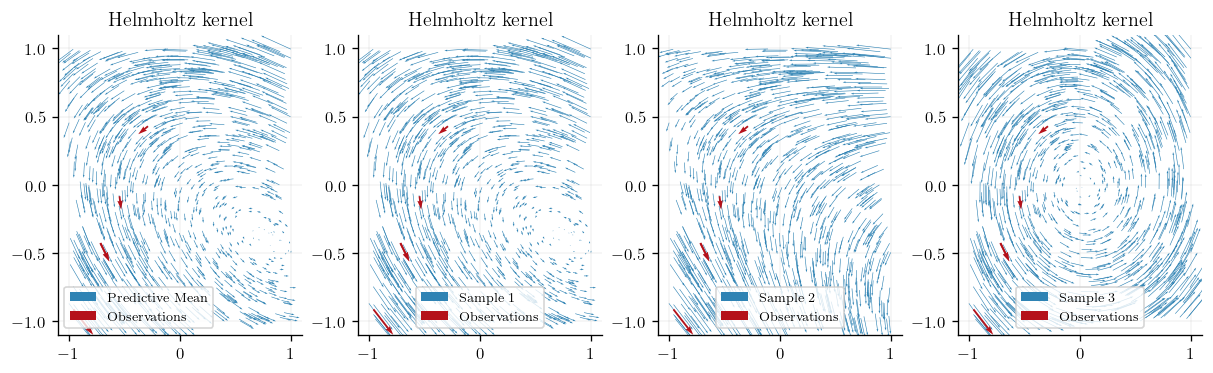

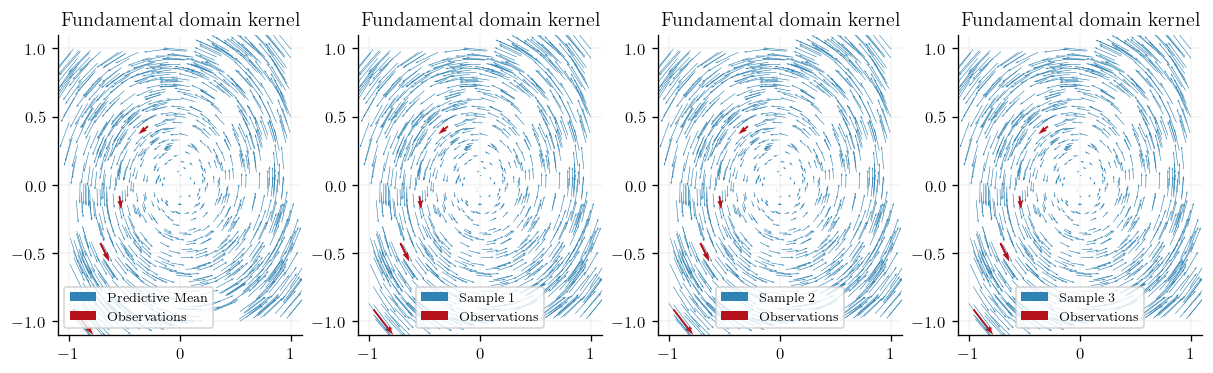

In [5]:
def f(X): # [N, d] -> [N, 2]
    return jnp.stack([-1 * X[:,1], X[:,0]],-1)

n_train = 5
X_1 = jr.uniform(key, (n_train, 1), minval=-1, maxval=-0.0) # [N, 1]
X_2 = jr.uniform(key, (n_train, 1), minval=-1, maxval=1) # [N, 1]
X = jnp.hstack([X_1, X_2]) # [N, 2]
Y = f(X)

n_test = 1000
X_test = jr.uniform(key, (n_test, 2), minval=-1, maxval=1) # [N, d]
Y_test = f(X_test)

run_experient(X, Y, X_test, Y_test)

Optimization terminated successfully.
         Current function value: -18.335600
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
time to fit on 5 points and predict on 1000 for Standard SE kernel is 0.5993518829345703
Optimization terminated successfully.
         Current function value: -20.223577
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
time to fit on 5 points and predict on 1000 for Helmholtz kernel is 2.4320199489593506
Optimization terminated successfully.
         Current function value: -42.853770
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
time to fit on 5 points and predict on 1000 for Fundamental domain kernel is 0.8336431980133057


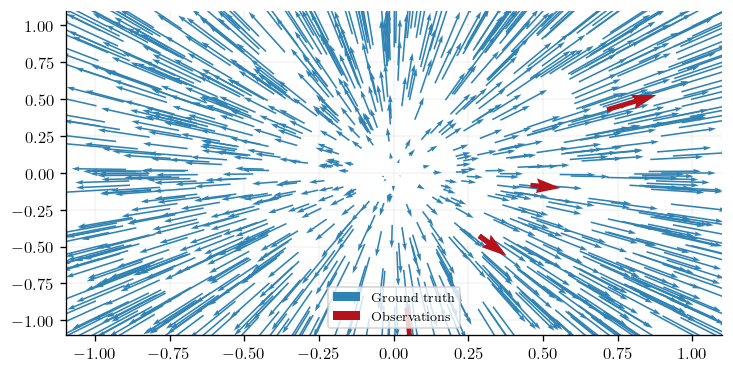

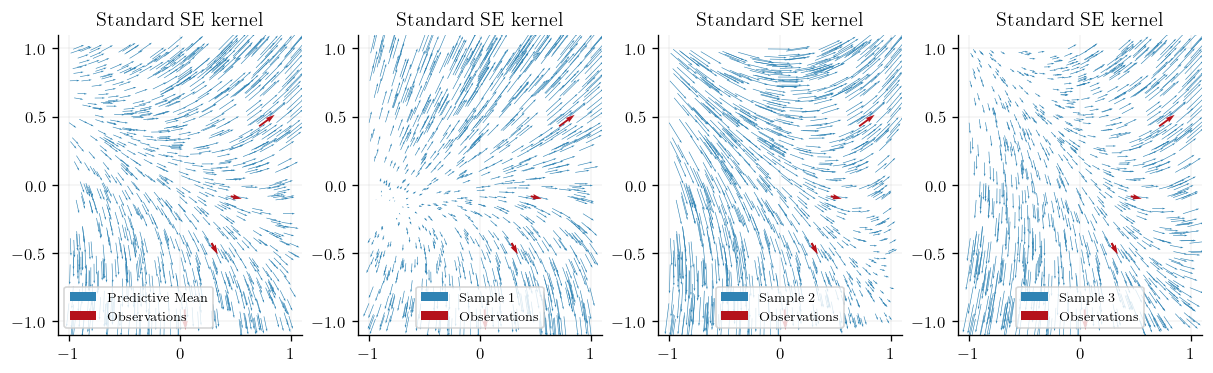

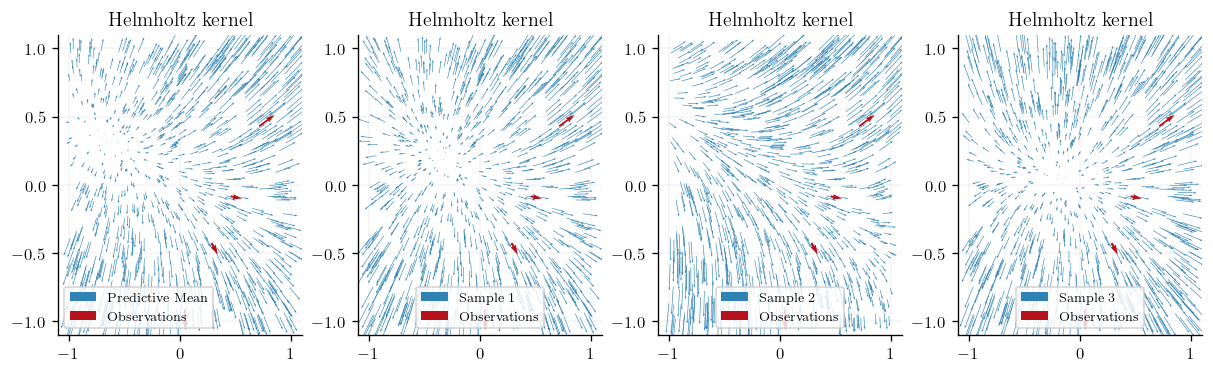

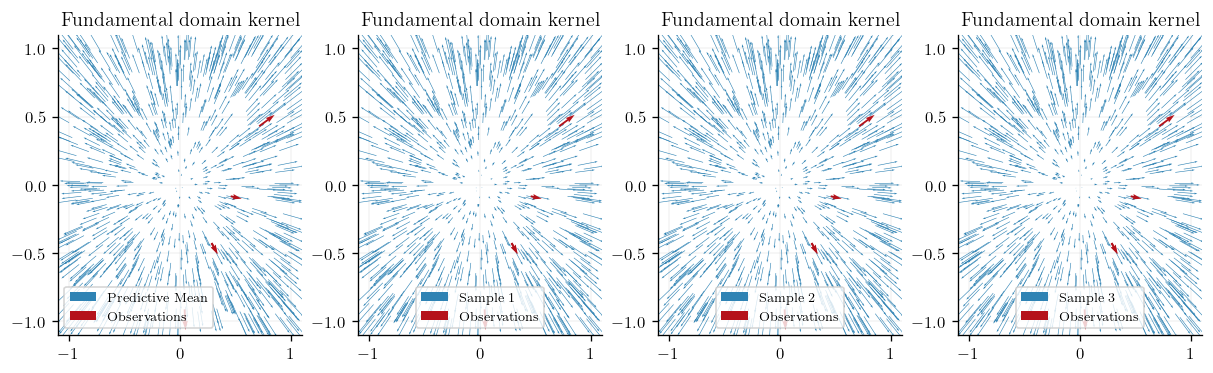

In [6]:
b=0.5
def f(X): # [N, d] -> [N, 2]
    X=X/2.0
    r = jnp.sum(X ** 2, axis=-1) # [N]
    return jnp.stack([X[:,0] / (b + r**2), X[:,1] / (b + r**2)],-1)

n_train = 5
X_1 = jr.uniform(key, (n_train, 1), minval=0, maxval=1) # [N, 1]
X_2 = jr.uniform(key, (n_train, 1), minval=-1, maxval=1) # [N, 1]
X = jnp.hstack([X_1, X_2]) # [N, 2]
Y = f(X)

n_test = 1000
X_test = jr.uniform(key, (n_test, 2), minval=-1, maxval=1) # [N, d]
Y_test = f(X_test)

run_experient(X, Y, X_test, Y_test)